# Attention Types in Transformers

This notebook demonstrates three core attention mechanisms used in Transformer architectures:

- **Encoder self-attention**: each encoder token attends to all encoder tokens.
- **Decoder masked self-attention**: each decoder token attends only to itself and past tokens (causal mask).
- **Encoder–decoder cross-attention**: decoder tokens attend over encoder tokens.

We use small toy sequences and visualize the resulting attention weight matrices.

**Note** that we are using random generator to initialise the embeddings. At this point any correlation between tokens is by chance and not indicative of semantic meaning.


In [13]:
import math
import random
from typing import Optional

import torch
import matplotlib.pyplot as plt

# Reproducibility
random.seed(42)
torch.manual_seed(42)


In [14]:

def plot_attention(attn_weights: torch.Tensor, x_ticks, y_ticks, title: str, figsize=(5, 4)) -> None:
    """Plot an attention matrix with tokens on axes.

    attn_weights: shape (num_queries, num_keys)
    """
    if attn_weights.is_cuda:
        attn_weights = attn_weights.cpu()
    matrix = attn_weights.detach().float().numpy()

    plt.figure(figsize=figsize, dpi=120)
    im = plt.imshow(matrix, aspect='auto', interpolation='nearest', cmap='viridis')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(x_ticks)), x_ticks, rotation=45, ha='right')
    plt.yticks(range(len(y_ticks)), y_ticks)
    plt.xlabel('Keys / Values')
    plt.ylabel('Queries')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
# Toy sequences and embeddings
encoder_tokens = ["I", "love", "natural", "language", "processing"]
decoder_tokens = ["<BOS>", "Transformers", "are", "powerful"]

# Embedding dimension (small for visualization)
d_model = 8

# Create deterministic random embeddings for each token
# In practice, these would be learned vectors or outputs of previous layers

def token_to_vector(token: str, dim: int) -> torch.Tensor:
    # Uses token hash as a seed for reproducible random vectors of the specified dimension per token.
    g = torch.Generator().manual_seed(abs(hash(token)) % (2**31))
    return torch.randn(dim, generator=g)

encoder_embeddings = torch.stack([token_to_vector(t, d_model) for t in encoder_tokens], dim=0)  # (S_e, d)
decoder_embeddings = torch.stack([token_to_vector(t, d_model) for t in decoder_tokens], dim=0)  # (S_d, d)
encoder_embeddings = torch.nn.functional.normalize(encoder_embeddings, dim=-1) #to normalize the chance effects in mbeddings
decoder_embeddings = torch.nn.functional.normalize(decoder_embeddings, dim=-1) #to normalize the chance effects in mbeddings

print("Encoder embeddings:", encoder_embeddings.shape)
print("Decoder embeddings:", decoder_embeddings.shape)


Encoder embeddings: torch.Size([5, 8])
Decoder embeddings: torch.Size([4, 8])


In [16]:
def scaled_dot_product_attention(Q: torch.Tensor,
                                  K: torch.Tensor,
                                  V: torch.Tensor,
                                  mask: Optional[torch.Tensor] = None):
    """Compute scaled dot-product attention.

    Shapes:
      Q: (S_q, d_k)
      K: (S_k, d_k)
      V: (S_k, d_v)  [usually d_v = d_k]
      mask: optional boolean mask broadcastable to (S_q, S_k) where True means "mask out"/disallow.
    Returns:
      output: (S_q, d_v)
      attn:   (S_q, S_k)
    """
    d_k = Q.size(-1)
    scores = (Q @ K.T) / math.sqrt(d_k)  # (S_q, S_k)
    if mask is not None:
        # mask=True positions are set to -inf so softmax -> 0
        scores = scores.masked_fill(mask, float('-inf'))
    attn = torch.softmax(scores, dim=-1)
    output = attn @ V  # (S_q, d_v)
    return output, attn

# Simple linear projections (identity here for clarity)
# In real Transformers, Q, K, V are produced by learned linear layers per head.
identity = torch.nn.Identity()

def make_qkv(embeddings: torch.Tensor):
    return identity(embeddings), identity(embeddings), identity(embeddings)


Encoder self-attention weights: torch.Size([5, 5])


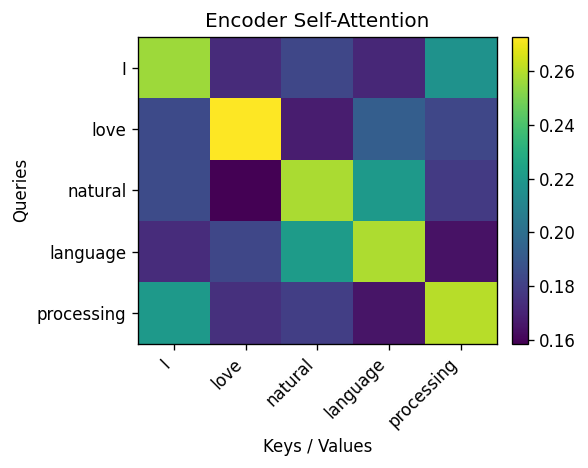

In [17]:
# Encoder self-attention: queries, keys, values all from encoder
Q_e, K_e, V_e = make_qkv(encoder_embeddings)  # (S_e, d)

_, attn_e = scaled_dot_product_attention(Q_e, K_e, V_e)
print("Encoder self-attention weights:", attn_e.shape)

plot_attention(
    attn_weights=attn_e,
    x_ticks=encoder_tokens,
    y_ticks=encoder_tokens,
    title="Encoder Self-Attention"
)


Decoder masked self-attention weights: torch.Size([4, 4])


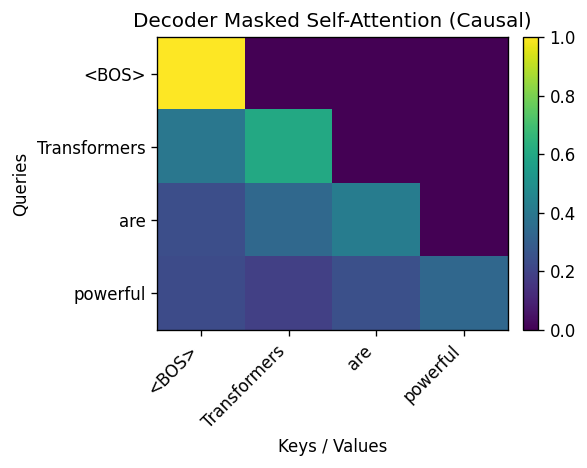

In [18]:
# Decoder masked self-attention: causal mask prevents attending to future tokens
Q_d, K_d, V_d = make_qkv(decoder_embeddings)  # (S_d, d)
S_d = Q_d.size(0)

# Create a boolean mask where True indicates positions to disallow (upper triangle above the diagonal)
causal_mask = torch.triu(torch.ones(S_d, S_d, dtype=torch.bool), diagonal=1)

_, attn_d_masked = scaled_dot_product_attention(Q_d, K_d, V_d, mask=causal_mask)
print("Decoder masked self-attention weights:", attn_d_masked.shape)

plot_attention(
    attn_weights=attn_d_masked,
    x_ticks=decoder_tokens,
    y_ticks=decoder_tokens,
    title="Decoder Masked Self-Attention (Causal)"
)


Cross-attention weights: torch.Size([4, 5])


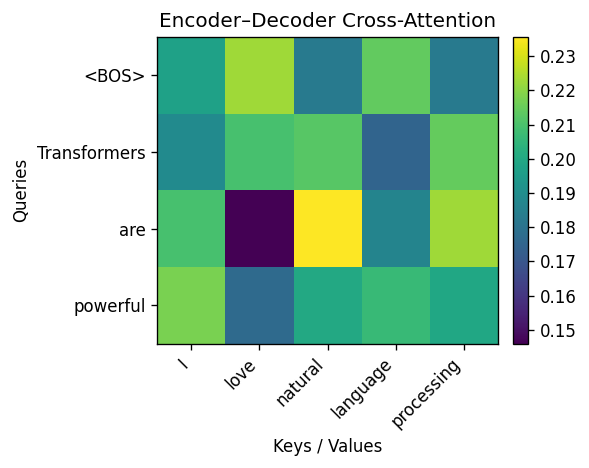

In [19]:
# Encoder–decoder cross-attention: queries from decoder, keys/values from encoder
Q_x = decoder_embeddings  # queries from decoder
K_x = encoder_embeddings  # keys from encoder
V_x = encoder_embeddings  # values from encoder

_, attn_cross = scaled_dot_product_attention(Q_x, K_x, V_x)
print("Cross-attention weights:", attn_cross.shape)

plot_attention(
    attn_weights=attn_cross,
    x_ticks=encoder_tokens,
    y_ticks=decoder_tokens,
    title="Encoder–Decoder Cross-Attention"
)


The queries (decoder) and keys/values (encoder) are random, untrained vectors with identity projections, so their dot products are centered at 0 with variance ≈ 1/d. With d_model=8, random peaks appear and softmax accentuates them. As mentioned at the start, there is no semantic link between encoder and decoder tokens here; any apparent alignment is based on chance and will change with the seed/hash. In real models, cross-attention becomes meaningful because Q/K/V come from learned projections over contextualized encoder/decoder states trained to align.